In [14]:
!nvidia-smi

Fri Dec  8 16:21:31 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   29C    P8     9W / 180W |    821MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 35%   52C    P2    63W / 180W |   1928MiB /  8114MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [15]:
### Imports ####################################################################
%matplotlib inline
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU
from typing import Tuple, Callable, List, Optional
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True)
Tensor = theano.tensor.Tensor

In [16]:
### File Writers ###############################################################
def write4d(file, array: np.ndarray) -> None:
    for cube in array:
        for matrix in cube:
            for row in matrix:
                for number in row:
                    string = "{0: >6.2f} | ".format(number)
                    string = string.replace("-0.00", "     ")
                    string = string.replace( "0.00",  "    ")
                    file.write(string)
                file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write3d(file, array: np.ndarray) -> None:
    for matrix in array:
        for row in matrix:
            for number in row:
                string = "{0: >6.2f} | ".format(number)
                string = string.replace("-0.00", "     ")
                string = string.replace( "0.00",  "    ")
                file.write(string)
            file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write(filename: str, array: np.ndarray) -> None:
    with open(filename, "w") as file:
        if len(array.shape) == 4:
            write4d(file, array)
        elif len(array.shape) == 3:
            write3d(file, array)
        else:
            file.write(str(array))

In [17]:
### Load in Data ###############################################################
order  = ["phi", "r", "z"]
frame  = pd.read_csv("data/sets/ACTS-MU10-PT1000-T50-PREPARED.gz")
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(len(data))
print(input_shape)
print(output_shape)
n = 3
visuals.display_matrices(data[n], matrix[n], order=order, noise=False)

65407
(200, 3)
(200, 52)


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,1.471408,31.959895,-192.97200,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.483444,71.842967,-371.65000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.500341,71.842967,-432.62400,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.508099,31.959895,-219.80000,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,2.665143,31.959895,-31.34380,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2.673906,71.842967,-89.13750,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,2.683948,115.818695,-155.34100,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2.696099,171.809967,-235.49400,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,2.991512,31.959895,7.66250,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,2.998506,71.842967,81.51560,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [18]:
### Run this cell if you want all events to have max number of hits ############
def regularize_frame(
        frame      : pd.DataFrame,
        num_layers : int,  # How many layers (hits per track).
        num_tracks : int,  # How many tracks per event.
        ) -> pd.DataFrame:
    regular = []
    events = (e for _, e in frame[frame["padding"] == 0].groupby("event_id"))
    for event in events:
        groups = event.groupby("cluster_id")
        tracks = groups.filter(lambda track: num_layers == len(track))
        if num_tracks <= len(pd.unique(tracks["cluster_id"])):
            ids    = tracks["cluster_id"]
            unique = np.sort(pd.unique(ids))
            mapped = dict((v, u) for (u, v) in enumerate(unique))
            tracks = tracks.assign(cluster_id=ids.map(mapped))
            tracks = tracks[tracks["cluster_id"] < num_tracks]
            if num_tracks == len(pd.unique(tracks["cluster_id"])):
                regular.append(tracks)
    return pd.concat(regular)

frame  = regularize_frame(frame, 4, 5)
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(input_shape)
print(output_shape)
n = 0
visuals.display_matrices(data[5], matrix[5], order=order, noise=False, padding=False)

(20, 3)
(20, 5)


,phi,r,z,A,B,C,D,E
0,0.359041,31.959895,-43.811200,1,,,,
1,0.364652,71.842967,-2.973750,1,,,,
2,0.370255,115.818695,41.352800,1,,,,
3,0.377614,171.809967,99.881200,1,,,,
4,0.399905,171.809967,10.076600,,1,,,
5,0.411684,115.818695,3.915560,,1,,,
6,0.420956,71.842967,-0.960523,,1,,,
7,0.429232,31.959895,-5.496880,,1,,,
8,0.460835,171.809967,33.715600,,,1,,
9,0.470633,115.818695,19.653100,,,1,,


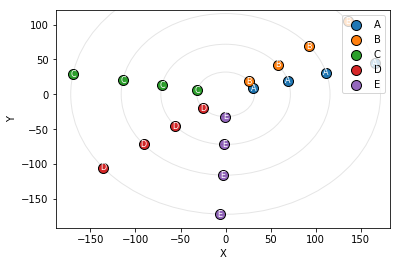

In [6]:
visuals.Plot2D(frame[frame["event_id"] == 0], order).plot(mode="xy", title="")

In [19]:
#### LossFunctionCreator #######################################################
class LossFunctionCreator:
    def __init__(self,
            input_tensor : Tensor,
            input_shape  : Tuple,
            output_shape : Tuple,
            order        : List[str],
            ) -> None:
        """ Initialize the instance variables. """
        self.__name__     = "LossFunctionCreator"
        self.input_tensor = T.as_tensor_variable(input_tensor)
        self.meshgrid     = self.make_meshgrid(output_shape)
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.order        = order

    def make_meshgrid(self,
            shape : Tuple[int, int],
            ) -> Tensor:
        """
        Create a meshgrid.
        Example for shape (3, 5):
            [[0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4]]
        """
        return (T.mgrid[0:shape[0], 0:shape[1]][1])
    
    def regression_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        input_tensor = self.input_tensor
        tensor = None
        for i in range(output_shape[1]):  # For each track...
            pred_mask = self.get_track_mask(y_pred, i)
            true_mask = self.get_track_mask(y_true, i)
            pred_num_hits = pred_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            true_num_hits = true_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            pred_masked = pred_mask * input_tensor
            true_masked = true_mask * input_tensor
            pred_line = self.linear_regression(pred_masked, pred_num_hits)
            true_line = self.linear_regression(true_masked, true_num_hits)
            #diff   = (pred_line - true_line)**2
            diff   = (pred_num_hits - true_num_hits)**2
            tensor = diff if tensor is None else tensor + diff
        return tensor
    
    def softmax(self,
            tensor     : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the softmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        exponent = (refinement * tensor).exp()
        return exponent / exponent.sum(axis=axis, keepdims=True)

    def softargmax(self,
            tensor     : Tensor,
            indices    : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the argsoftmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        return (self.softmax(tensor, axis, refinement) * indices).sum(axis)
    
    def get_order_mask(self,
            string : str,
            ) -> Tensor:
        """
        Return a mask such that when output is multiplied by this mask,
        only the column corresponding to the *string* category remains.
        """
        mask = np.zeros(len(self.order))
        mask[self.order.index(string)] = 1
        return T.as_tensor_variable(mask)
    
    def get_track_mask(self,
            output   : Tensor,
            track_id : int,
            aref     : int = 32,  # Refinement value for softargmax.
            mref     : int =  4,  # Refinement value for mask values.
            ) -> Tensor:
        """
        Retrieve a tensor containing a mask such that if self.tensor_input
        was multiplied by the mask, the result would be a tensor containing
        the positions of all hits with the specified track_id.
        """
        cats = (output * self.meshgrid).sum(-1)
        fill = T.fill(cats, track_id)
        diff = (cats - fill)**2
        mask = 1 / (mref * diff).exp()
        mask = mask.reshape((*T.shape(mask), 1))
        return mask
    
    def linear_regression(self,
            tensor : Tensor,
            length : Tensor,
            ) -> Tensor:
        """
        Given a tensor, and the number of hits within the tensor,
        return the two parameters (m, b) of the least squares
        regression line with equation f[x] = (m * x) + b.
        """
        e = 2 * K.common.epsilon()  # Epsilon to avoid division by 0.
        p = (tensor * self.get_order_mask("phi")).sum(-1)
        r = (tensor * self.get_order_mask("r")).sum(-1)  # r values.
        z = (tensor * self.get_order_mask("z")).sum(-1)  # z values.
        d = (length * (r**2).sum(-1)) - r.sum(-1)**2 + e  # Denominator.
        m = (length * (r * z).sum(-1) - r.sum(-1) * z.sum(-1)) / d
        b = (z.sum(-1) * (r**2).sum(-1) - r.sum(-1) * (r * z).sum(-1)) / d
        return m + b
    
    def __call__(self) -> Callable[[Tensor, Tensor], Tensor]:
        """ Return a Tensor that measures the loss of a model. """
        def custom_loss(y_true: Tensor, y_pred: Tensor) -> Tensor:
            return self.regression_loss(y_true, y_pred)
        return custom_loss

In [20]:
A = T.dtensor3("A")
B = T.dtensor3("B")
C = T.dtensor3("C")
D = LossFunctionCreator(A, input_shape, output_shape, order)()
E = D(B, C)
F = theano.function([A, B, C], E, on_unused_input='ignore')
# print(theano.printing.debugprint(E))

In [21]:
positions   = data  [0:4]
true_matrix = matrix[0:4]
pred_matrix = np.random.rand(*true_matrix.shape)
pred_matrix = pred_matrix / pred_matrix.sum(-1, keepdims=True)
evaluation = F(positions, true_matrix, pred_matrix).round(2)
print(evaluation)

[ 140.11  153.56   64.18  121.2 ]


In [9]:
visuals.display_matrices(data[0], true_matrix[0], 2, order, 0, 0)
visuals.display_matrices(data[0], pred_matrix[0], 2, order, 0, 0)

,phi,r,z,A,B,C,D,E
0,0.263837,171.809967,331.9900,1,,,,
1,0.272315,115.818695,217.9330,1,,,,
2,0.278982,71.842967,126.6710,1,,,,
3,0.285327,31.959895,42.4250,1,,,,
4,0.623917,31.959895,-65.9719,,1,,,
5,0.634346,71.842967,-120.6220,,1,,,
6,0.645621,115.818695,-180.6470,,1,,,
7,0.659898,171.809967,-256.4190,,1,,,
8,2.950621,31.959895,-47.8166,,,1,,
9,2.956995,71.842967,-78.4979,,,1,,


,phi,r,z,A,B,C,D,E
0,0.263837,171.809967,331.9900,0.318874,0.178911,0.145098,0.233410,0.123707
1,0.272315,115.818695,217.9330,0.328751,0.013350,0.129799,0.245605,0.282495
2,0.278982,71.842967,126.6710,0.029470,0.085150,0.348778,0.515732,0.020870
3,0.285327,31.959895,42.4250,0.306381,0.148215,0.323424,0.036753,0.185226
4,0.623917,31.959895,-65.9719,0.157241,0.273082,0.083707,0.276452,0.209519
5,0.634346,71.842967,-120.6220,0.344959,0.067078,0.250695,0.173100,0.164168
6,0.645621,115.818695,-180.6470,0.329447,0.391370,0.159435,0.064163,0.055584
7,0.659898,171.809967,-256.4190,0.085856,0.195476,0.152468,0.196140,0.370060
8,2.950621,31.959895,-47.8166,0.411367,0.136811,0.236723,0.029192,0.185908
9,2.956995,71.842967,-78.4979,0.372877,0.422609,0.040095,0.113896,0.050525


In [24]:
### Define Model ###############################################################
input_layer = Input(name="Input", shape=input_shape)
model_layer = Dense(name="Dense 1", units=128, activation="relu")(input_layer)
model_layer = Dense(name="Dense 2", units=128, activation="relu")(model_layer)
model_layer = Dense(name="Dense 3", units=128, activation="relu")(model_layer)
output_layer = Dense(name="Softmax", units=output_shape[1],
                     activation="softmax", kernel_initializer="uniform"
                    )(model_layer)
model = Model(inputs=input_layer, outputs=output_layer)
loss  = LossFunctionCreator(input_layer, input_shape, output_shape, order)()
opt   = keras.optimizers.Adadelta()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 20, 3)             0         
_________________________________________________________________
Dense 1 (Dense)              (None, 20, 128)           512       
_________________________________________________________________
Dense 2 (Dense)              (None, 20, 128)           16512     
_________________________________________________________________
Dense 3 (Dense)              (None, 20, 128)           16512     
_________________________________________________________________
Softmax (Dense)              (None, 20, 5)             645       
Total params: 34,181
Trainable params: 34,181
Non-trainable params: 0
_________________________________________________________________


In [25]:
### Fit Model ##################################################################
histories = model.fit(
    data, 
    matrix, 
    epochs=64, 
    batch_size=1,
    verbose=2, 
    validation_data=(data, matrix)
)
predictions = model.predict(data[0:2])
write("output.txt", predictions)

Train on 59220 samples, validate on 59220 samples
Epoch 1/64
101s - loss: 1.4448 - acc: 0.3469 - val_loss: 1.4110 - val_acc: 0.3580
Epoch 2/64
101s - loss: 1.4164 - acc: 0.3569 - val_loss: 1.3965 - val_acc: 0.3636
Epoch 3/64
101s - loss: 1.4140 - acc: 0.3587 - val_loss: 1.4370 - val_acc: 0.3543
Epoch 4/64
101s - loss: 1.4138 - acc: 0.3579 - val_loss: 1.4051 - val_acc: 0.3583
Epoch 5/64
101s - loss: 1.4119 - acc: 0.3587 - val_loss: 1.4017 - val_acc: 0.3595
Epoch 6/64
103s - loss: 1.4098 - acc: 0.3598 - val_loss: 1.4125 - val_acc: 0.3613
Epoch 7/64
104s - loss: 1.4096 - acc: 0.3605 - val_loss: 1.4227 - val_acc: 0.3620
Epoch 8/64
103s - loss: 1.4094 - acc: 0.3607 - val_loss: 1.4351 - val_acc: 0.3589
Epoch 9/64
103s - loss: 1.4092 - acc: 0.3595 - val_loss: 1.4241 - val_acc: 0.3573
Epoch 10/64
103s - loss: 1.4095 - acc: 0.3594 - val_loss: 1.4228 - val_acc: 0.3616
Epoch 11/64
103s - loss: 1.4103 - acc: 0.3589 - val_loss: 1.4028 - val_acc: 0.3636
Epoch 12/64
103s - loss: 1.4093 - acc: 0.3603 

KeyboardInterrupt: 

In [26]:
#### Graph Loss ################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

NameError: name 'histories' is not defined

In [ ]:
#### Graph Accuracy ############################################################
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()